# Generation of simulated datasets

Date: 25/04/2017

In [10]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict
from mmit.core.solver import compute_optimal_costs
from mmit.learning import MaxMarginIntervalTree
from mmit.metrics import mean_squared_error, zero_one_loss
from mmit.model import TreeExporter
from mmit.model_selection import GridSearchCV
from time import time

## Interval generation functions

In [11]:
def generate_intervals_full_random(n_intervals, mean_y=0., open_interval_proba=0.3):
    lower = np.random.rand(n_intervals)**2
    upper = lower + np.random.rand(n_intervals)**2
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
            
    return np.array(zip(lower, upper))

def generate_intervals_random_width(n_intervals, base_y=0., width_std=0., open_interval_proba=0.3):  
    lower = base_y - np.random.normal(loc=0., scale=width_std, size=n_intervals)
    upper = base_y + np.random.normal(loc=0., scale=width_std, size=n_intervals)
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
           
    return np.array(zip(lower, upper))

def generate_intervals_fixed_width(n_intervals, mean_y=0., std_y=0., interval_width=0.1, open_interval_proba=0.3):  
    interval_centers = np.random.normal(loc=mean_y, scale=std_y, size=n_intervals)
    lower = interval_centers - interval_width
    upper = interval_centers + interval_width
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
           
    return np.array(zip(lower, upper))

### Fixed-width interval generation

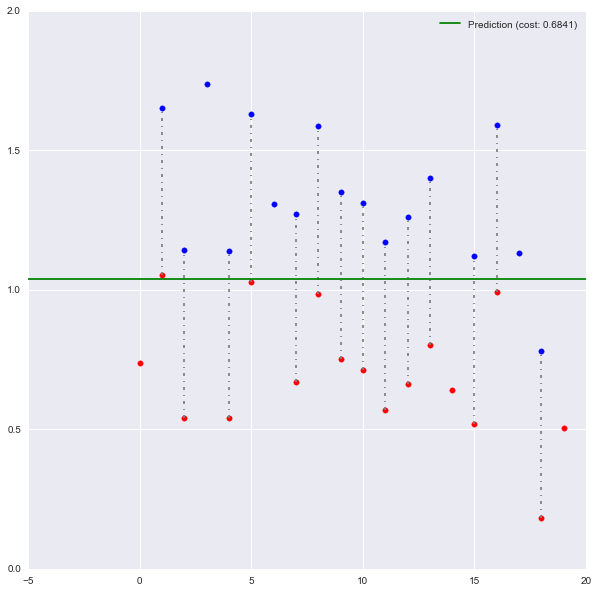

In [12]:
y = generate_intervals_fixed_width(n_intervals=20, mean_y=1., std_y=0.3, interval_width=0.3, open_interval_proba=0.31)

_, preds, costs = compute_optimal_costs(np.array(zip(*y)[0], dtype=np.double), np.array(zip(*y)[1], dtype=np.double), 
                                    0.1, 0)

plt.clf()
plt.scatter(np.arange(len(y)), zip(*y)[0], color="red", s=30)
plt.scatter(np.arange(len(y)), zip(*y)[1], color="blue", s=30)
plt.vlines(np.arange(len(y)), zip(*y)[0], zip(*y)[1], color="grey", linestyle="-.")
plt.axhline(preds[-1], color="green", label="Prediction (cost: {0:.4f})".format(costs[-1]))
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()

## Olympics datasets

In [13]:
def generate_olympic_dataset(n_examples = 200, n_groups=5, linear=False, open_interval_proportion=0.1):
    n_ex_by_group = n_examples / n_groups
    
    X = None
    y = None
    
    cmap = ["#0000FF", "#FFFF00", "#000000", "#00FF00", "#FF0000"] + sns.color_palette("hls", 8)
    plt.clf()
    for i in xrange(n_groups):
        # Position of the group
        x1 = float(i)
        x2 = float((i + 1) % 2)
        
        # Generate the group's intervals
        if linear:
            mean_y = i
        else:
            mean_y = np.exp(i)
        group_y = generate_intervals_fixed_width(n_intervals=n_ex_by_group, 
                                                 mean_y=mean_y, 
                                                 std_y=0.3, 
                                                 interval_width=0.3, 
                                                 open_interval_proba=open_interval_proportion)
        group_X = np.random.multivariate_normal([x1, x2], [[0.08, 0.], [0., 0.08]], size=len(group_y))
        
        # Save the group X and y values
        if X is None:
            X = group_X
            y = group_y
        else:
            X = np.vstack((X, group_X))
            y = np.vstack((y, group_y))
        
        # Plot this group
        _, preds, costs = compute_optimal_costs(np.array(zip(*group_y)[0], dtype=np.double), 
                                                np.array(zip(*group_y)[1], dtype=np.double), 0., 0)
        plt.scatter(zip(*group_X)[0], zip(*group_X)[1], color=cmap[i % len(cmap)], label="{0:.4f}".format(preds[-1]))
    
    # Show the plot
    plt.gcf().set_size_inches(10, 10)
    plt.legend()
    plt.show()
    
    return X, y

### Olympics linear

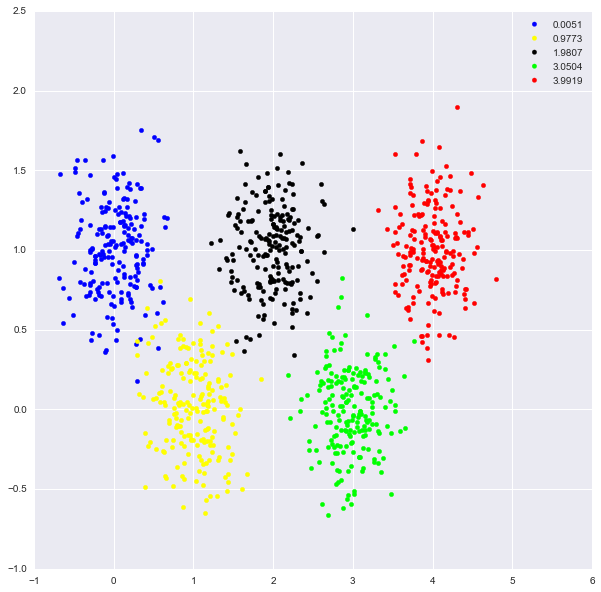

In [14]:
n_folds = 5
X, y = generate_olympic_dataset(n_groups=5, linear=True, n_examples=1000)
folds = np.arange(X.shape[0]) % n_folds + 1
np.random.shuffle(folds)

ds_dir = "data/simulated.olympics.linear"
if not os.path.exists(ds_dir):
    os.mkdir(ds_dir)
    
open(os.path.join(ds_dir, "features.csv"), "w").writelines(["x1, x2\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(xi[0], xi[1]) for xi in X])
open(os.path.join(ds_dir, "targets.csv"), "w").writelines(["min.log.penalty, max.log.penalty\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(yi[0], yi[1]) for yi in y])
open(os.path.join(ds_dir, "folds.csv"), "w").writelines(["fold\n"] + ["{0:d}\n".format(f) for f in folds])

### Olympics non-linear

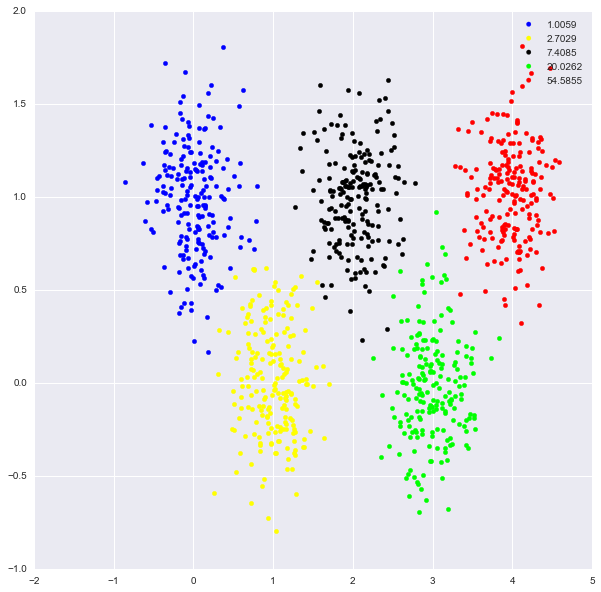

In [15]:
n_folds = 5
X, y = generate_olympic_dataset(n_groups=5, linear=False, n_examples=1000)
folds = np.arange(X.shape[0]) % n_folds + 1
np.random.shuffle(folds)

ds_dir = "data/simulated.olympics.nonlinear"
if not os.path.exists(ds_dir):
    os.mkdir(ds_dir)
    
open(os.path.join(ds_dir, "features.csv"), "w").writelines(["x1, x2\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(xi[0], xi[1]) for xi in X])
open(os.path.join(ds_dir, "targets.csv"), "w").writelines(["min.log.penalty, max.log.penalty\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(yi[0], yi[1]) for yi in y])
open(os.path.join(ds_dir, "folds.csv"), "w").writelines(["fold\n"] + ["{0:d}\n".format(f) for f in folds])

## One relevant dimension

### 1-D function datasets (with irrelevant features)

simulated.stepwise.log.5.0.010
40


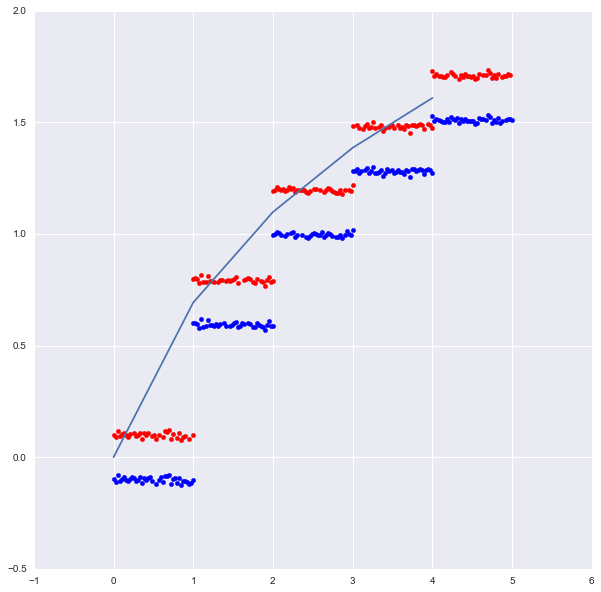

simulated.stepwise.log.5.0.018
40


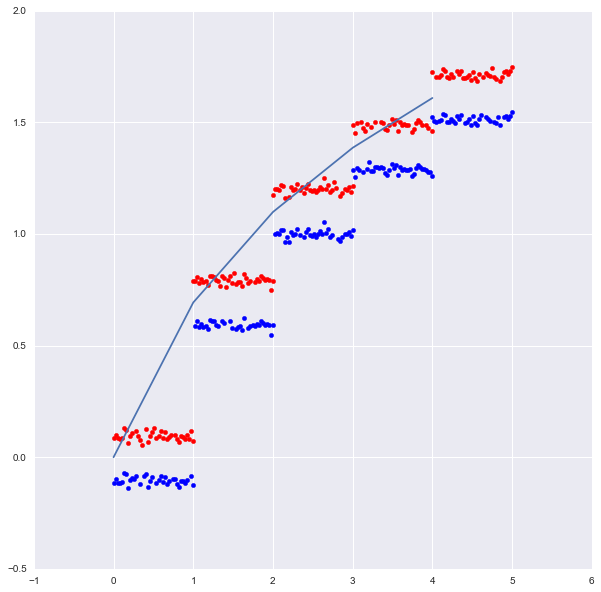

simulated.stepwise.log.5.0.032
40


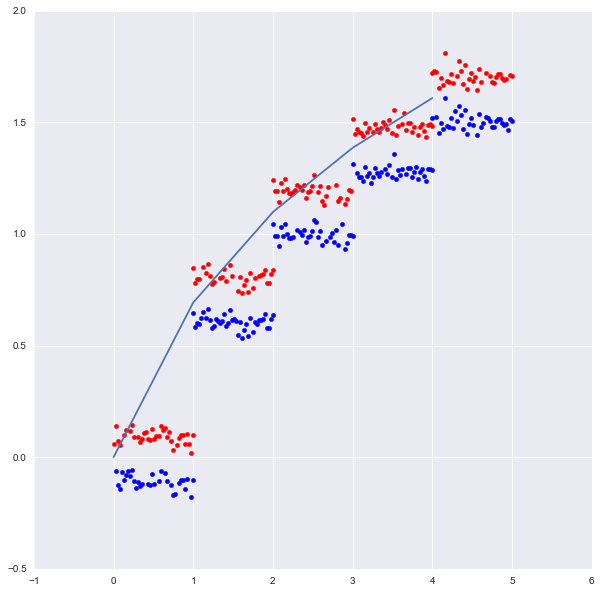

simulated.stepwise.log.5.0.056
40


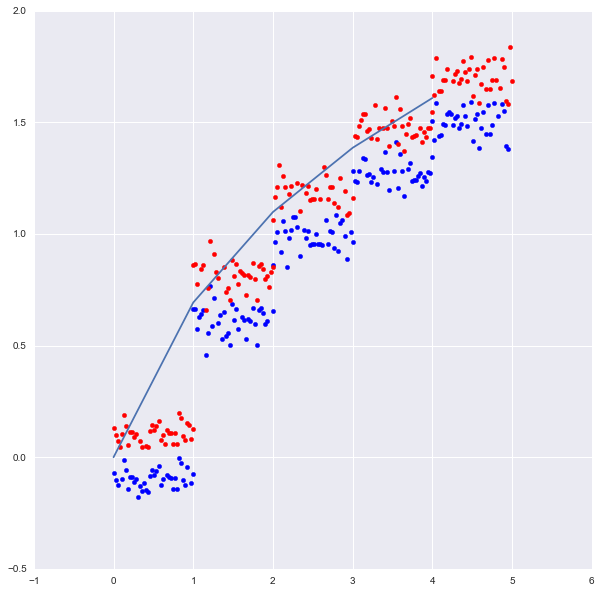

simulated.stepwise.log.5.0.100
40


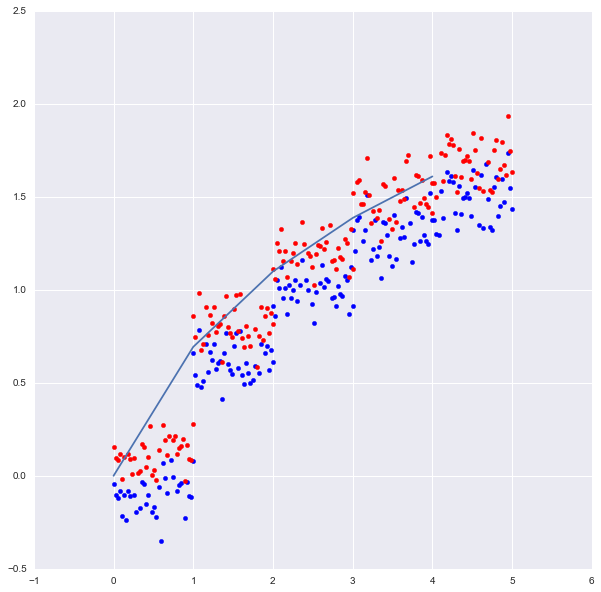

simulated.stepwise.log.10.0.010
20


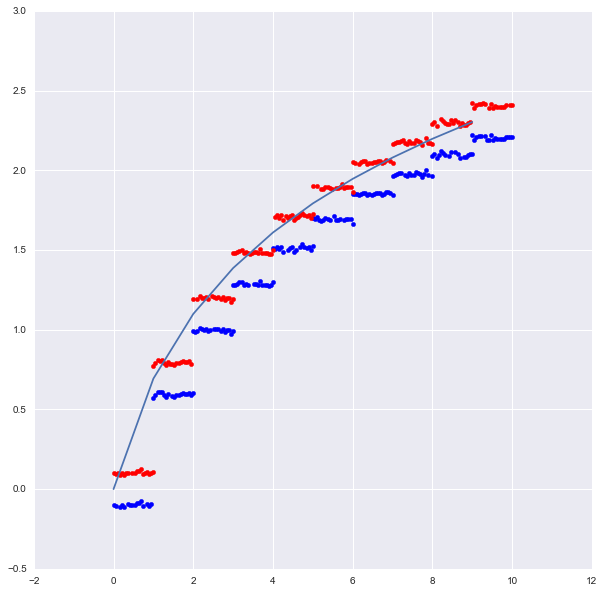

simulated.stepwise.log.10.0.018
20


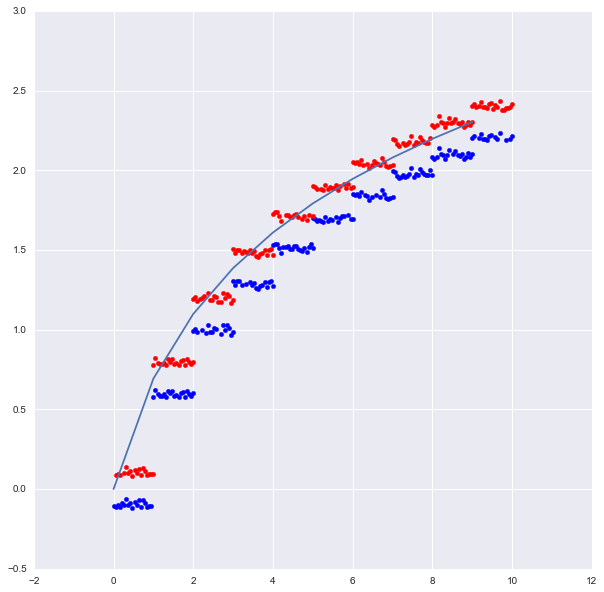

simulated.stepwise.log.10.0.032
20


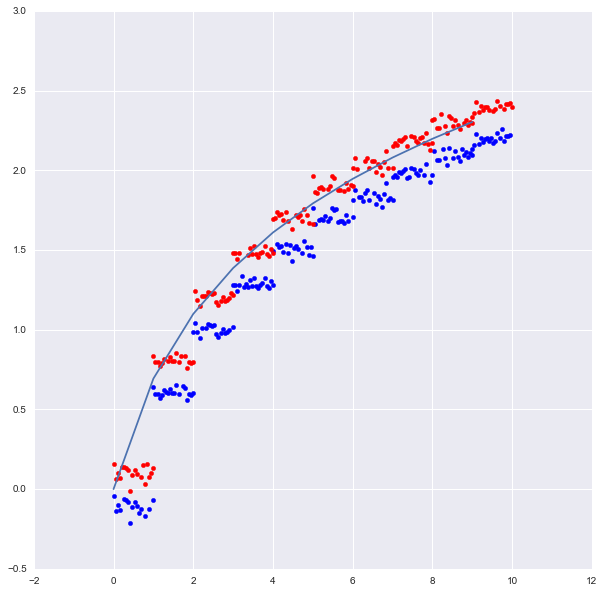

simulated.stepwise.log.10.0.056
20


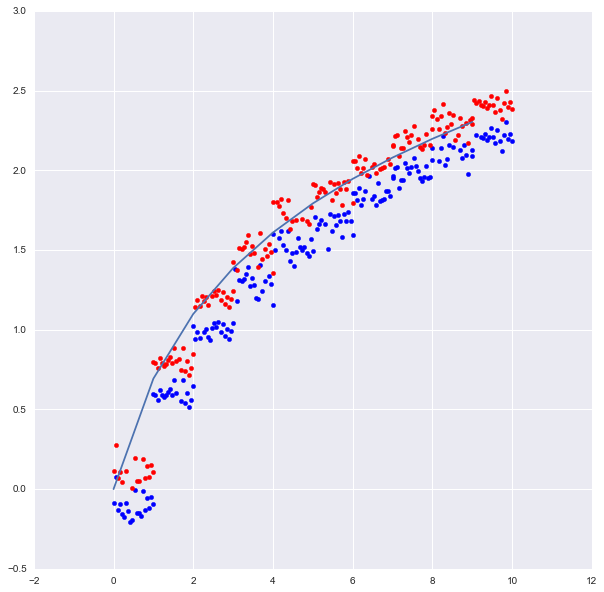

simulated.stepwise.log.10.0.100
20


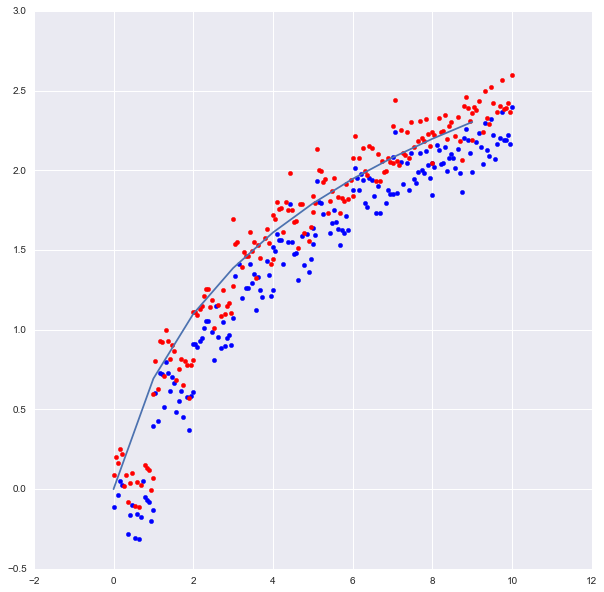

simulated.stepwise.log.40.0.010
5


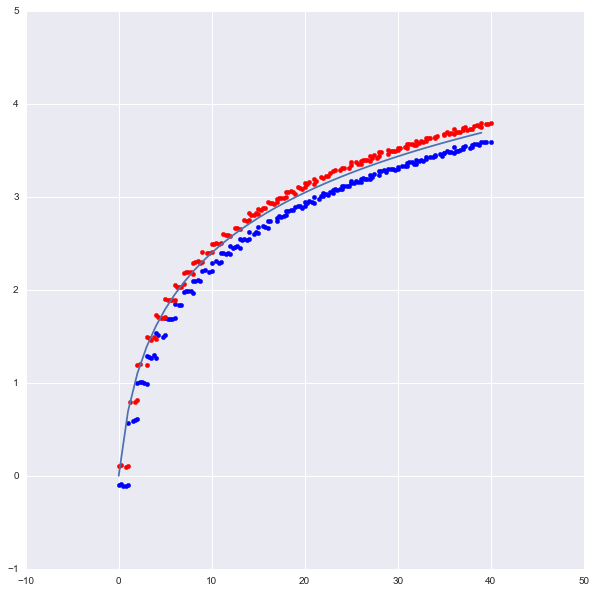

simulated.stepwise.log.40.0.018
5


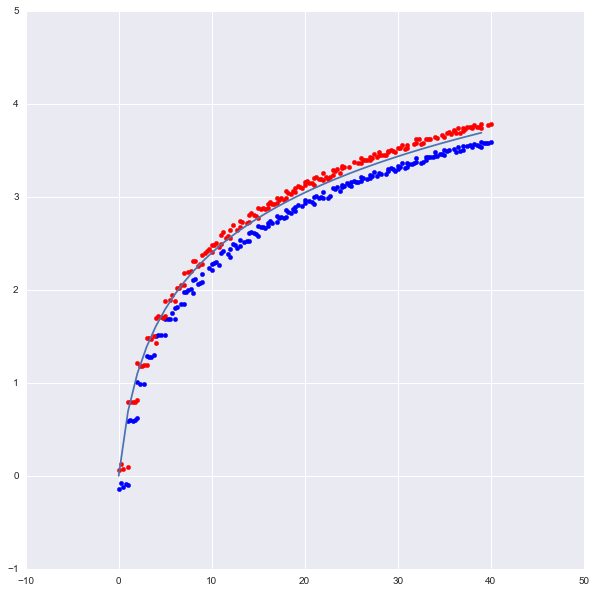

simulated.stepwise.log.40.0.032
5


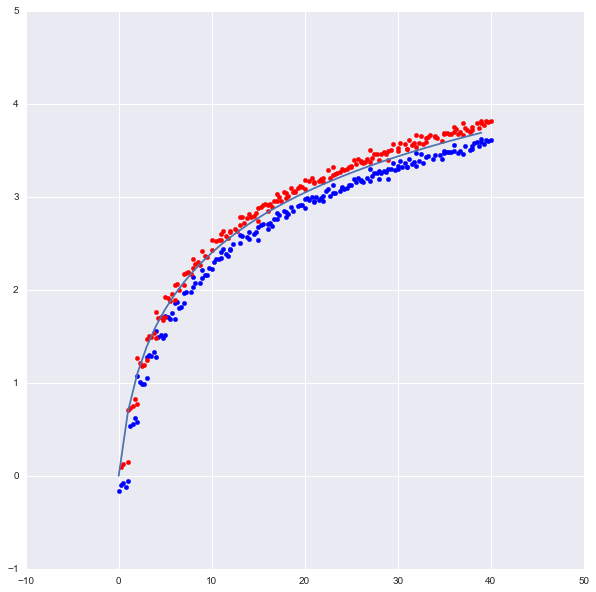

simulated.stepwise.log.40.0.056
5


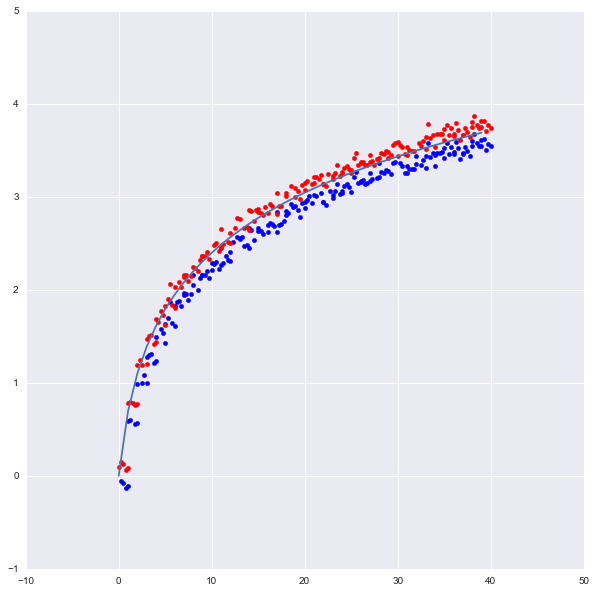

simulated.stepwise.log.40.0.100
5


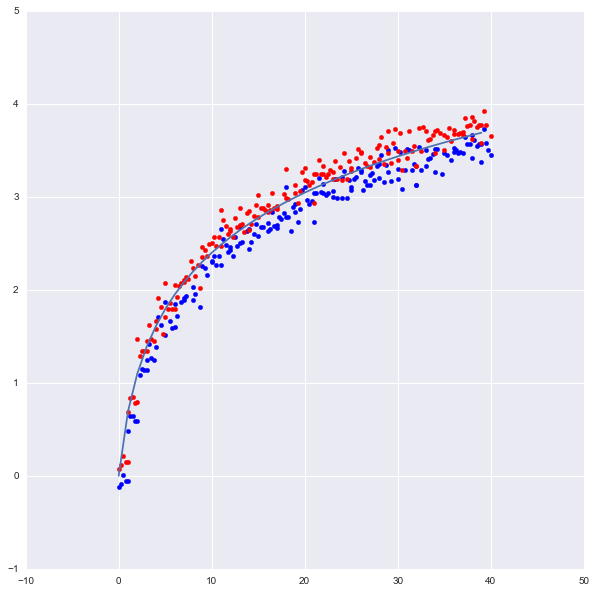

simulated.stepwise.linear.5.0.010
40


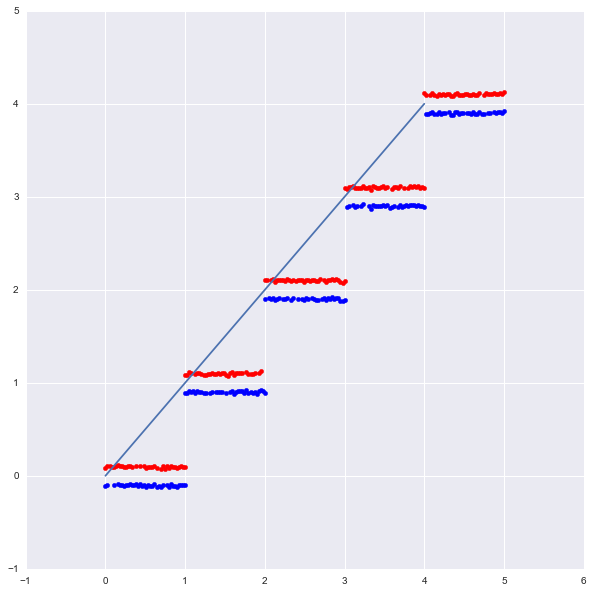

simulated.stepwise.linear.5.0.024
40


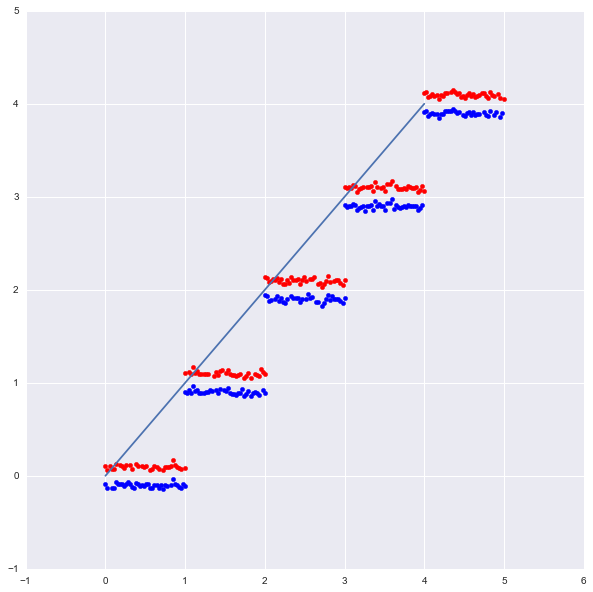

simulated.stepwise.linear.5.0.056
40


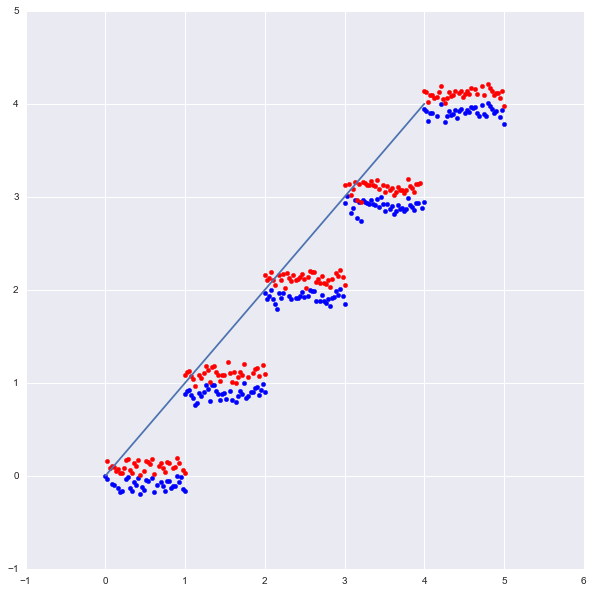

simulated.stepwise.linear.5.0.133
40


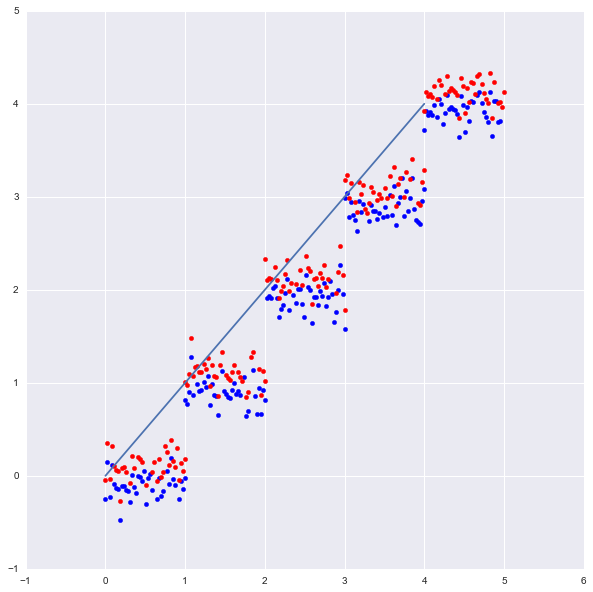

simulated.stepwise.linear.5.0.316
40


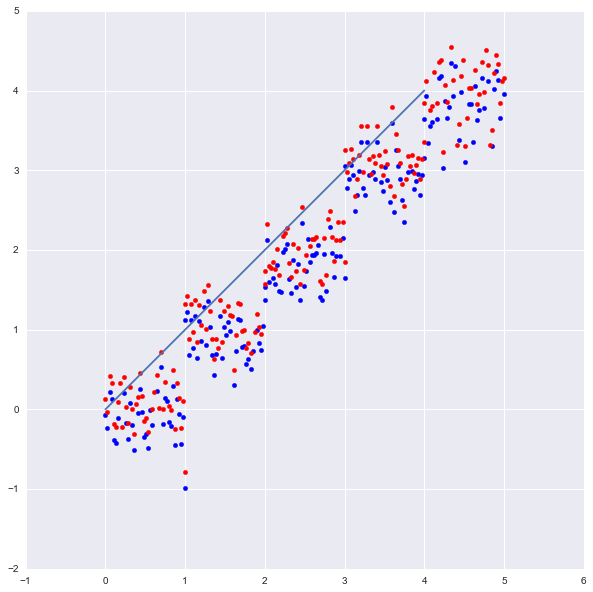

simulated.stepwise.linear.10.0.010
20


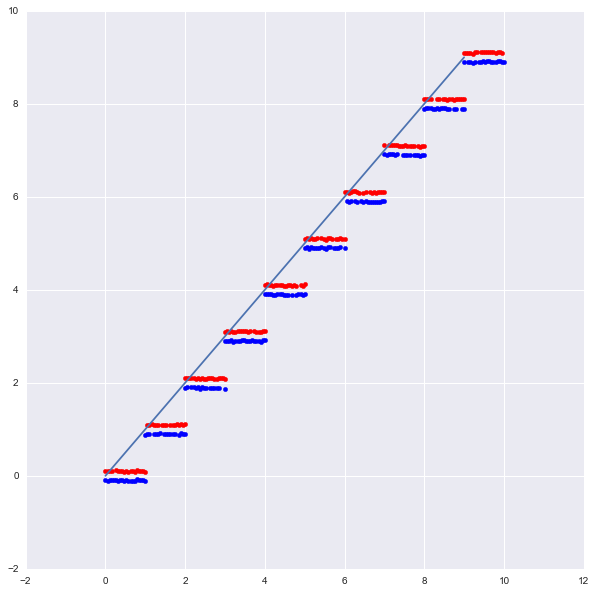

simulated.stepwise.linear.10.0.024
20


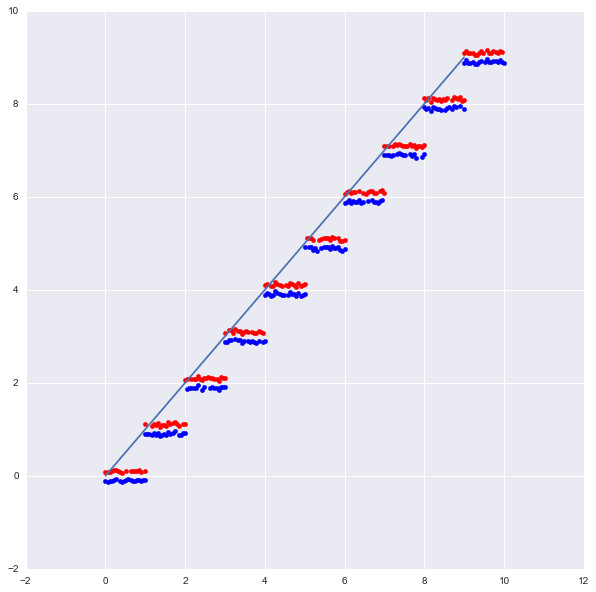

simulated.stepwise.linear.10.0.056
20


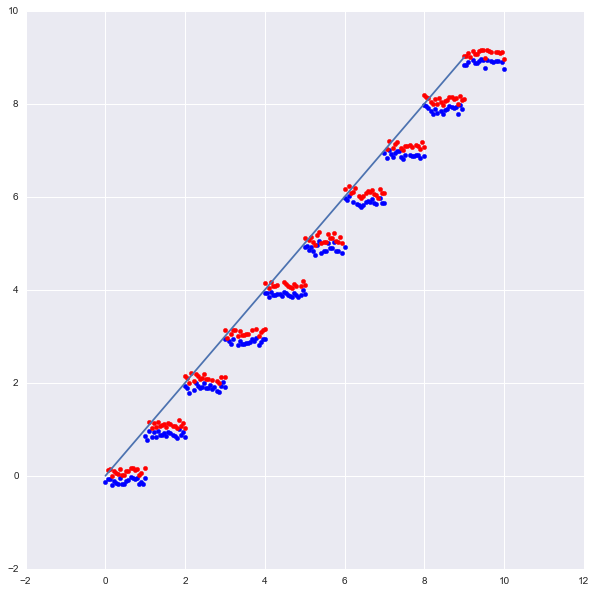

simulated.stepwise.linear.10.0.133
20


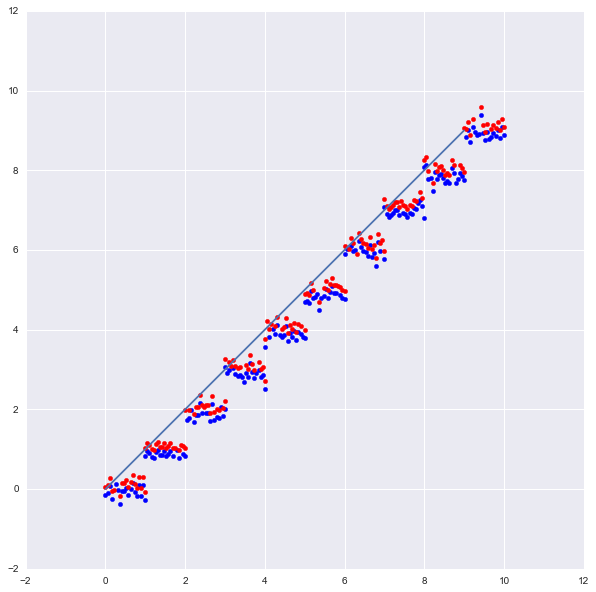

simulated.stepwise.linear.10.0.316
20


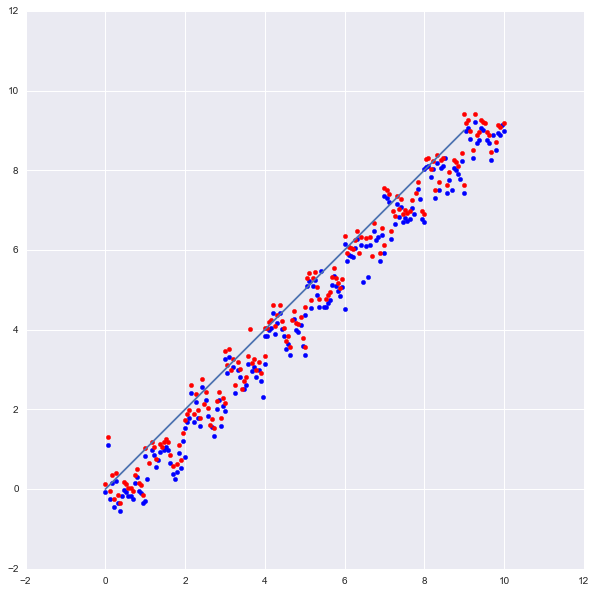

simulated.stepwise.linear.40.0.010
5


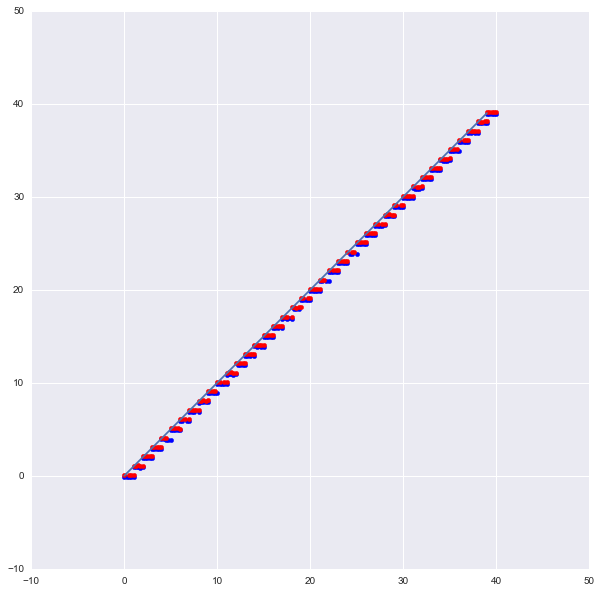

simulated.stepwise.linear.40.0.024
5


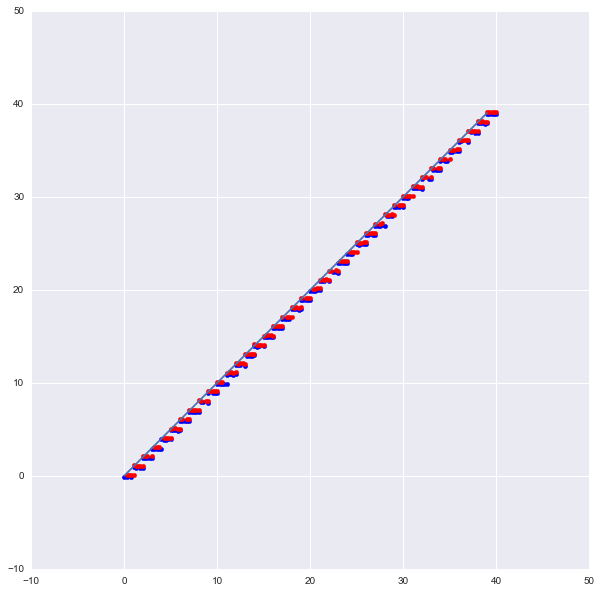

simulated.stepwise.linear.40.0.056
5


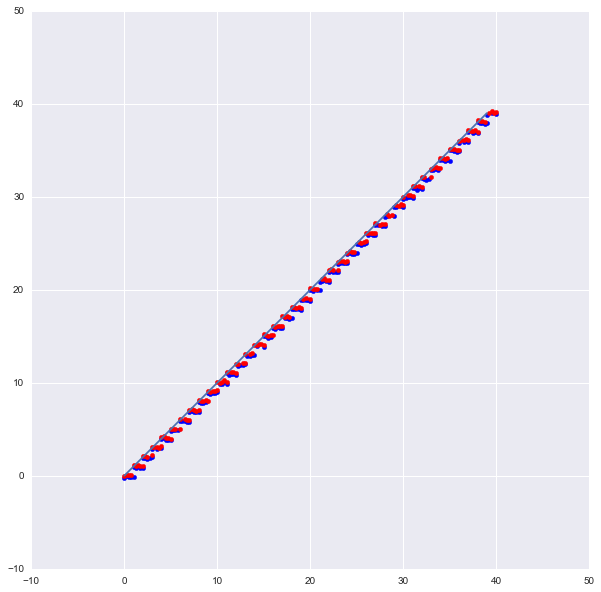

simulated.stepwise.linear.40.0.133
5


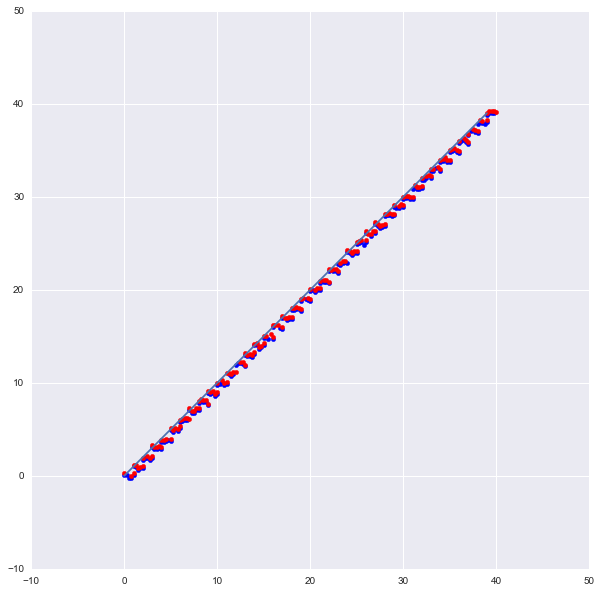

simulated.stepwise.linear.40.0.316
5


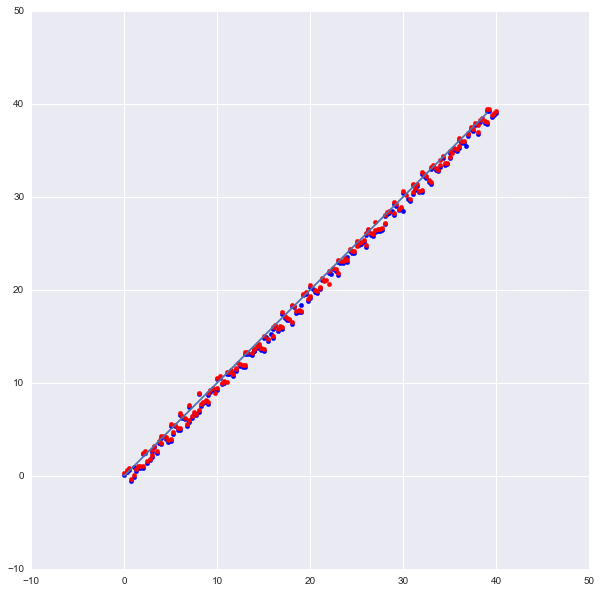

simulated.continuous.linear.40.0.010
1


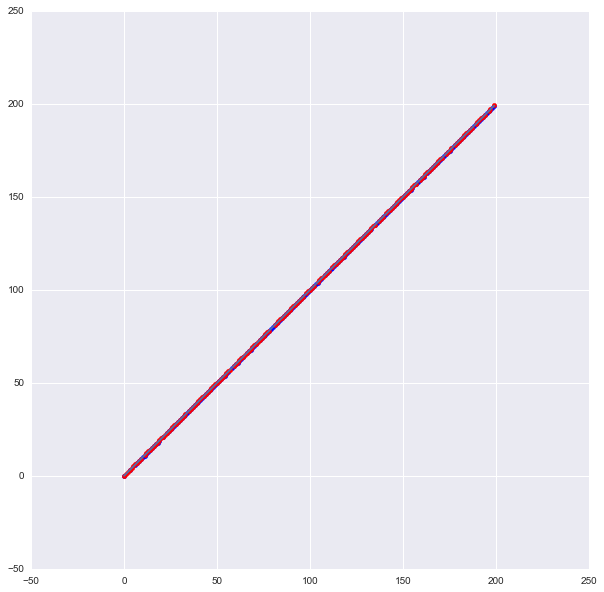

simulated.continuous.linear.40.0.024
1


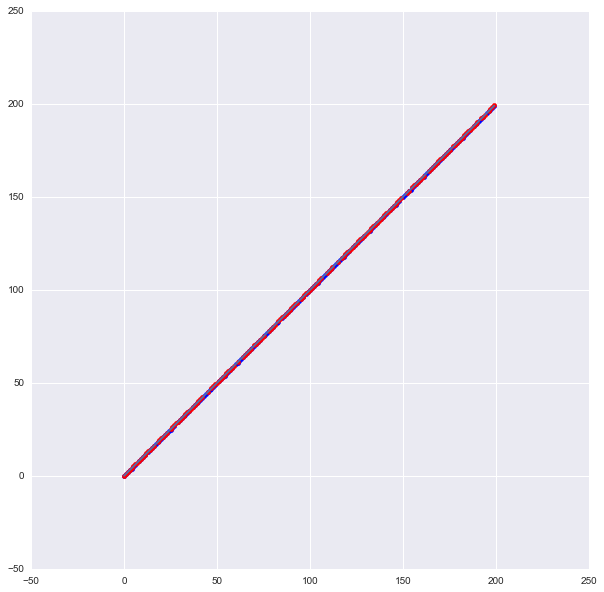

simulated.continuous.linear.40.0.056
1


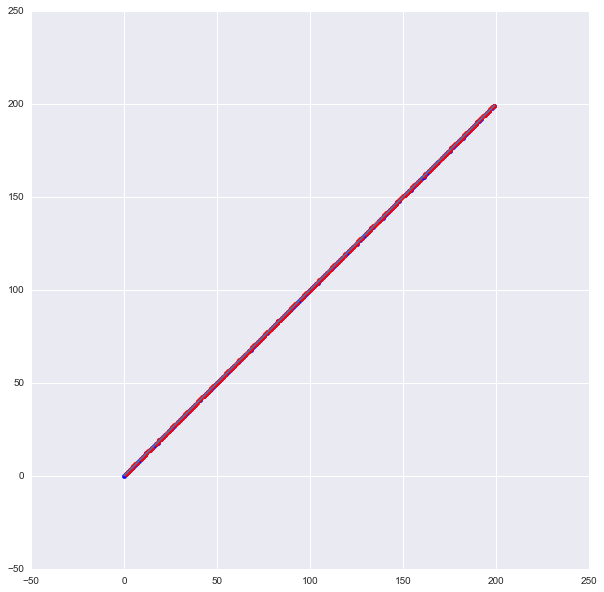

simulated.continuous.linear.40.0.133
1


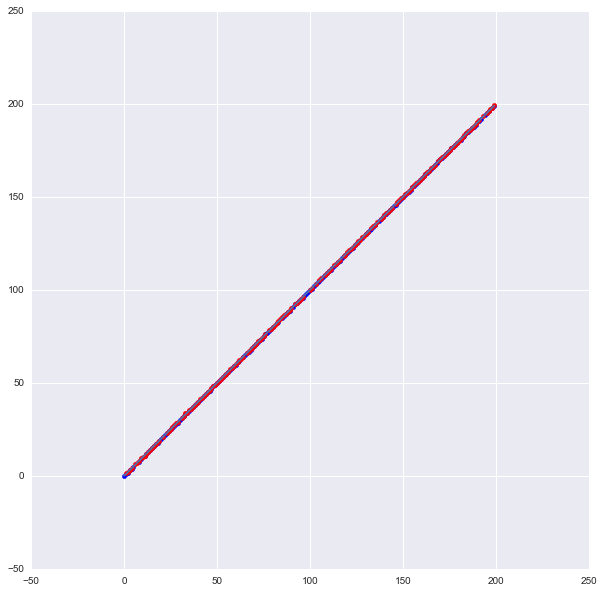

simulated.continuous.linear.40.0.316
1


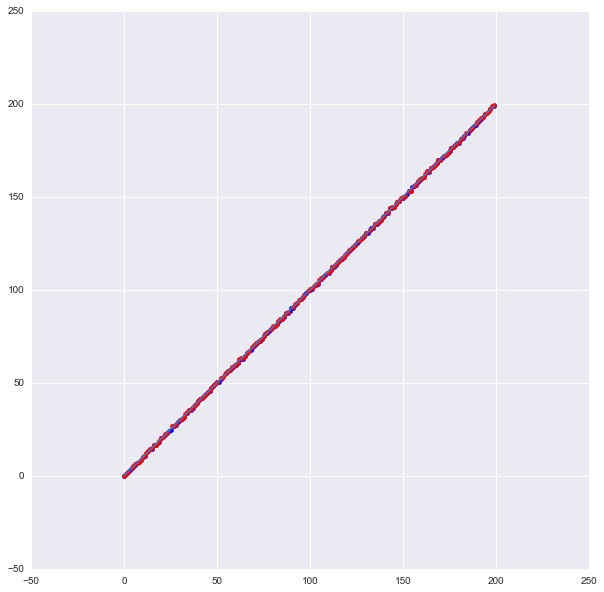

In [21]:
def generate_piecewise_constant_function_dataset(func, n_examples, n_noise_features, n_steps, n_folds,
                                                 interval_center_noise, open_interval_proba):
    n_examples_per_step = n_examples / n_steps

    X = np.random.rand(n_examples, n_noise_features + 1)
    y = np.zeros((n_examples, 2))

    for i in xrange(n_steps):
        X[n_examples_per_step * i : n_examples_per_step * (i  + 1), 0] = np.linspace(i, i + 1, n_examples_per_step)
        y[n_examples_per_step * i : n_examples_per_step * (i + 1)] = \
            generate_intervals_fixed_width(n_intervals=n_examples_per_step, 
                                           mean_y=func(i), 
                                           std_y=interval_center_noise,
                                           open_interval_proba=open_interval_proba)
        
    plt.clf()
    plt.scatter(X[:, 0], y[:, 0], color="blue")
    plt.scatter(X[:, 0], y[:, 1], color="red")
    plt.plot(np.arange(n_steps), func(np.arange(n_steps)))
    plt.gcf().set_size_inches(10, 10)
    plt.show()
        
    return X, y

def save_dataset(X, y, folds, name):
    ds_dir = "data/{0!s}".format(name)
    if not os.path.exists(ds_dir):
        os.mkdir(ds_dir)
        
    open(os.path.join(ds_dir, "features.csv"), "w").writelines(["x1, x2\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(xi[0], xi[1]) for xi in X])
    open(os.path.join(ds_dir, "targets.csv"), "w").writelines(["min.log.penalty, max.log.penalty\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(yi[0], yi[1]) for yi in y])
    open(os.path.join(ds_dir, "folds.csv"), "w").writelines(["fold\n"] + ["{0:d}\n".format(f) for f in folds])
    

n_examples = 200
n_folds = 5
folds = np.arange(n_examples) % n_folds + 1
np.random.shuffle(folds)

for n_steps in [5, 10, 40]:
    for noise_level in np.logspace(-2, -1, 5):
        dataset_name = "simulated.stepwise.log.{0:d}.{1:.3f}".format(n_steps, noise_level)
        print dataset_name
        X, y = generate_piecewise_constant_function_dataset(lambda x: np.log(x + 1), 
                                                            n_examples=200, n_noise_features=19, n_steps=n_steps, n_folds=5,
                                                            interval_center_noise=noise_level, open_interval_proba=0.2)
        save_dataset(X, y, folds, dataset_name)

for n_steps in [5, 10, 40]:
    for noise_level in np.logspace(-2, -0.5, 5):
        dataset_name = "simulated.stepwise.linear.{0:d}.{1:.3f}".format(n_steps, noise_level)
        print dataset_name
        X, y = generate_piecewise_constant_function_dataset(lambda x: x, 
                                                            n_examples=200, n_noise_features=19, n_steps=n_steps, n_folds=5,
                                                            interval_center_noise=noise_level, open_interval_proba=0.2)
        save_dataset(X, y, folds, dataset_name)

for noise_level in np.logspace(-2, -0.5, 5):
    dataset_name = "simulated.continuous.linear.{0:d}.{1:.3f}".format(n_steps, noise_level)
    print dataset_name
    X, y = generate_piecewise_constant_function_dataset(lambda x: x, 
                                                        n_examples=200, n_noise_features=19, n_steps=200, n_folds=5,
                                                        interval_center_noise=noise_level, open_interval_proba=0.2)
    save_dataset(X, y, folds, dataset_name)